In [ ]:
import xgboost
from xgboost import XGBRegressor
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

data = pd.read_csv('./test_data.csv')

def phrase_recstrct(data, t1, t2, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input series: x(t-n, ... t-1)
    for i in range(t1, 0, -1):
        cols.append(df.shift(i))
    # output series: x(t, t+1, ... t+n)
    for i in range(0, t2):
        cols.append(df.shift(-i))
    # concat input and output series:
    agg = pd.concat(cols, axis=1)
    # remove nulls
    if dropnan:
        agg.dropna(inplace=True)

    return agg.values

def train_test_split(data, test_length):
    return data[:-test_length, :], data[-test_length:, :]

def xgboost_forecast(train, test_x):
    # convert list into array:
    train = np.asarray(train)
    # split x and y:
    train_x, train_y = train[:, :-1], train[:, -1]
    # Model Parameters:
    model = XGBRegressor(objective='reg:squarederror',
                         n_estimators=1000)

    # Model Fitting:
    model.fit(train_x, train_y)
    # Prediction:
    yhat = model.predict([test_x])
    return yhat[0]


def walk_forward_validation(data, pred_length, t1, t2):
    predictions = list()
    # split dataset:
    train, test = train_test_split(data, pred_length)

    history = [x for x in train]

    # Test every point in Test set:
    for i in range(len(test)):
        # split test data set as input and output:
        test_x, test_y = test[i, :-1], test[i, -1]
        # forecast based on history data (just observed)
        yhat = xgboost_forecast(history, test_x)
        # save prediction results
        predictions.append(yhat)

        ### To make a long time range predict, Append PREDICTED VALUES to the history!! 
        # history.append(test[i])
        series_update = np.concatenate((train[-1][i+1:], np.asarray(predictions)))
        history.append(series_update[- (t1 + t2):])

        print('>> Ture=%.1f, Pred=%.1f, %d / %d' % (test_y, yhat, i + 1, pred_length))
    
    # Error Claculator:
    MAE = mean_absolute_error(test[:, -1], predictions)
    MSE = mean_squared_error(test[:, -1], predictions)
    R2 = r2_score(test[:, -1], predictions)
    error = [MAE, MSE, R2]

    return error, test[:, 1], predictions

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


>> Ture=22908.9, Pred=20060.6, 1 / 50
>> Ture=23822.1, Pred=21924.8, 2 / 50
>> Ture=23847.6, Pred=23281.0, 3 / 50
>> Ture=23653.5, Pred=22979.7, 4 / 50
>> Ture=23379.7, Pred=23029.3, 5 / 50
>> Ture=23333.7, Pred=22862.2, 6 / 50
>> Ture=23053.8, Pred=22917.6, 7 / 50
>> Ture=22860.4, Pred=22840.9, 8 / 50
>> Ture=22678.4, Pred=22899.1, 9 / 50
>> Ture=23225.0, Pred=22496.7, 10 / 50
>> Ture=22984.6, Pred=22933.5, 11 / 50
>> Ture=23197.6, Pred=22726.5, 12 / 50
>> Ture=23823.7, Pred=22997.9, 13 / 50
>> Ture=23203.7, Pred=23255.3, 14 / 50
>> Ture=23948.8, Pred=22890.7, 15 / 50
>> Ture=23948.8, Pred=23013.9, 16 / 50
>> Ture=24411.4, Pred=22872.1, 17 / 50
>> Ture=24433.7, Pred=22813.6, 18 / 50
>> Ture=24312.5, Pred=22849.4, 19 / 50
>> Ture=24179.0, Pred=22772.8, 20 / 50
>> Ture=23913.3, Pred=22786.6, 21 / 50
>> Ture=23359.4, Pred=22712.6, 22 / 50
>> Ture=23248.4, Pred=22803.3, 23 / 50
>> Ture=20945.8, Pred=22706.7, 24 / 50
>> Ture=21175.2, Pred=21200.4, 25 / 50
>> Ture=21615.8, Pred=21184.2, 26 

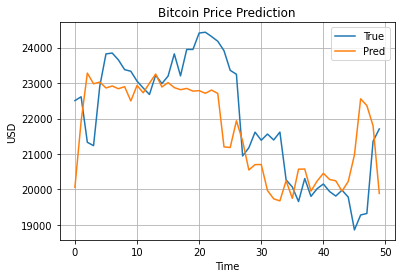

 Evaluation: 
 MAE = 721.14 
 MSE = 861326.87 
 R2  = 0.69 


In [ ]:
t1 = 6
t2 = 0
reconstructed_data = phrase_recstrct(list(data['prices']), t1, t2)

pred_length = 50
error, y, yhat = walk_forward_validation(reconstructed_data, pred_length, t1, t2)

plt.plot(y, label='True')
plt.plot(yhat, label='Pred')
plt.grid(True)
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('USD')
plt.legend()
plt.show()
print(' ====== \n Evaluation: \n MAE = %.2f \n MSE = %.2f \n R2  = %.2f \n ======' % (error[0],
                                                                                      error[1],
                                                                                      error[2]))